In [1]:
import pandas as pd
import verde as vd
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
# Leer los datos desde un archivo Excel
data = pd.read_excel('data/tmean.xlsx')
data.head()

,CodigoEstacion,Latitud,Longitud,Altitud,Fecha,Valor_max,Valor_min,Valor_medio
0,23195502,7.121472,-73.184528,1189,2000-01-01,23.965188,17.560887,20.763038
1,23195502,7.121472,-73.184528,1189,2000-02-01,24.037069,17.985632,21.011351
2,23195502,7.121472,-73.184528,1189,2000-03-01,24.156183,18.191250,21.173716
3,23195502,7.121472,-73.184528,1189,2000-04-01,24.881111,18.677917,21.779514
4,23195502,7.121472,-73.184528,1189,2000-05-01,24.751049,18.933286,21.842167


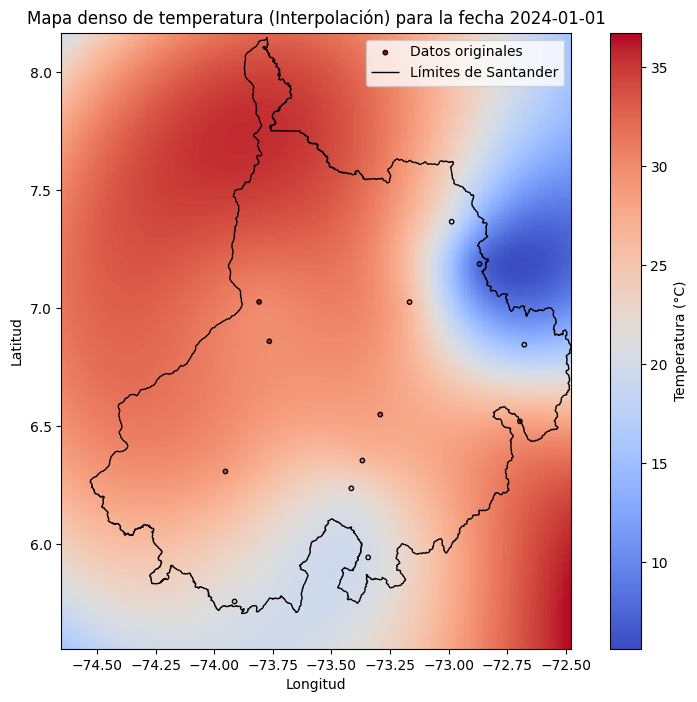

In [4]:
# Convertir la columna de fecha a formato datetime para facilitar el filtrado
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Seleccionar los registros de una fecha específica
fecha_objetivo = '2024-01-01'  # Cambia esto a la fecha que desees analizar
data_fecha = data[data['Fecha'] == fecha_objetivo]

# Verificar que haya datos para esa fecha
if data_fecha.empty:
    print(f"No se encontraron datos para la fecha {fecha_objetivo}")
else:
    # Extraer las columnas relevantes
    latitudes = data_fecha['Latitud'].values
    longitudes = data_fecha['Longitud'].values
    temperaturas = data_fecha['Valor_medio'].values

    # Crear una malla densa para la interpolación
    region = (longitudes.min()-0.7, longitudes.max()+0.2, latitudes.min()-0.2, latitudes.max()+0.8)
    spacing = 0.01  # Define el espacio entre los puntos de la malla en grados
    grid = vd.grid_coordinates(region, spacing=spacing)

    # Interpolación usando Verde Spline
    interp = vd.Spline()  # Configurar el interpolador Spline
    interp.fit((longitudes, latitudes), temperaturas)  # Ajustar el interpolador a los datos

    # Predecir valores en la malla densa
    grid_temperatura = interp.predict(grid)

    # Cargar el archivo de límites administrativos de Colombia con Geopandas
    colombia_shapefile = 'data/aoi/Departamento.shp'  # Archivo SHP o GeoJSON con límites de municipios
    gdf = gpd.read_file(colombia_shapefile)

    # Reproyectar los datos geográficos a WGS84 (EPSG:4326)
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    # Filtrar para mostrar solo el departamento de Santander
    santander_gdf = gdf[gdf['DeNombre'] == 'Santander']  # Asegúrate de que coincida con el nombre en el archivo

    # Graficar el mapa de temperatura interpolado
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(grid[0], grid[1], grid_temperatura, cmap='coolwarm', shading='auto')
    plt.colorbar(label='Temperatura (°C)')

    # Graficar los puntos de datos originales
    plt.scatter(longitudes, latitudes, c=temperaturas, s=10, edgecolor='k', cmap='coolwarm', label='Datos originales')

    # Superponer los límites geográficos de los municipios de Santander
    santander_gdf.boundary.plot(ax=plt.gca(), linewidth=1, edgecolor="black", label="Límites de Santander")

    # Limitar los ejes al área de interés
    plt.xlim(region[0], region[1])
    plt.ylim(region[2], region[3])

    # Etiquetas y título
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title(f'Mapa denso de temperatura (Interpolación) para la fecha {fecha_objetivo}')
    plt.legend()
    plt.show()